# Wrangle and Analyse data from the WeRateDogs Twitter account
### by Elzani Viljoen

## Gathering the data

In [80]:
# importing necessary libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import tweepy
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [81]:
# opening the provided csv file as a dataframe
t_archive=pd.read_csv('twitter-archive-enhanced.csv')

In [82]:
t_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


I will only be looking at the original tweets, therefore no retweets. I will therefore remove all entries where 'retweeted_status_id' has an input other than NaN.

In [83]:
t_archive_new = t_archive[t_archive['retweeted_status_id'].isnull()]

In [84]:
t_archive_new.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


I will now programatically download the image predictions file:

In [85]:
response = requests.get(' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [86]:
with open('image_predictions.tsv',mode ='wb') as file:
    file.write(response.content)

In [87]:
image_pred = pd.read_csv('image_predictions.tsv',sep='\t')

In [88]:
image_pred.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Next, I will use Python's Tweepy library to query the Twitter API for each tweet's JSON data.
I will store this data in a text file.

In [10]:
consumer_key = '####'
consumer_secret = '####'
access_token = '####'
access_secret = '####'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

In [11]:
tweet = api.get_status(892420643555336193,tweet_mode='extended')
tweet

Status(_api=<tweepy.api.API object at 0x115a47550>, _json={'created_at': 'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': '892420643555336193', 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", 'truncated': False, 'display_text_range': [0, 85], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h

In [502]:
type(tweet)

tweepy.models.Status

In [12]:
tweet_json = tweet._json
print(tweet_json['id'])

892420643555336193


In [13]:
import pprint

In [14]:
pprint.pprint(tweet_json)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
              'media': [{'display_url': 'pic.twitter.com/MgUWQ76dJU',
                         'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
                         'id': 892420639486877696,
                         'id_str': '892420639486877696',
                         'indices': [86, 109],
                         'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
                         'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
                         'sizes': {'large': {'h': 528,
                                             'resize': 'fit',
                                             'w': 540},
                                   'medium': {'h': 528,
                                              'resize': 'fit',
                                    

In [15]:
tweet_json['retweet_count']

8646

In [16]:
tweet_json['favorite_count']

38980

In [17]:
t_archive.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [18]:
pd.set_option('display.max_colwidth', -1)

In [19]:
import time

data = []  
start = time.time()
#print('start '+ str(start))
count = 0
for i in t_archive_new.tweet_id:
    print(i)
    
    tweet = api.get_status(i,tweet_mode='extended')
    tweet_id_var = int(i)
    tweet_json = tweet._json
    retweet_count= tweet_json['retweet_count']
    
    favorite_count = tweet_json['favorite_count']
    
    data.append({'id':tweet_id_var,'retweet_count': retweet_count,'favorite_count': favorite_count })
    
    #print(data)
    count=count+1
    if count%100==0:
        #time.sleep(10)
        midtime=time.time()
        print("time passed "+ str((midtime-start)/60) +'mins')
    
        
              
    
end=time.time()
#print('end '+str(end/60)+' mins')
print('total time '+str((end-start)/60)+' mins')
    

892420643555336193
892177421306343426
891815181378084864
891689557279858688
891327558926688256
891087950875897856
890971913173991426
890729181411237888
890609185150312448
890240255349198849
890006608113172480
889880896479866881
889665388333682689
889638837579907072
889531135344209921
889278841981685760
888917238123831296
888804989199671297
888554962724278272
888078434458587136
887705289381826560
887517139158093824
887473957103951883
887343217045368832
887101392804085760
886983233522544640
886736880519319552
886680336477933568
886366144734445568
886267009285017600
886258384151887873
885984800019947520
885528943205470208
885518971528720385
885167619883638784
884925521741709313
884876753390489601
884562892145688576
884441805382717440
884247878851493888
884162670584377345
883838122936631299
883482846933004288
883360690899218434
883117836046086144
882992080364220416
882762694511734784
882627270321602560
882268110199369728
882045870035918850
881906580714921986
881666595344535552
881633300179

811985624773361665
811744202451197953
811647686436880384
811627233043480576
811386762094317568
810984652412424192
810896069567610880
810657578271330305
810284430598270976
810254108431155201
809920764300447744
809448704142938112
809220051211603969
809084759137812480
808838249661788160
808733504066486276
808501579447930884
808344865868283904
808106460588765185
808001312164028416
807621403335917568
807106840509214720
807010152071229440
806629075125202948
806576416489959424
806542213899489280
806219024703037440
805932879469572096
805826884734976000
805520635690676224
805487436403003392
805207613751304193
804738756058218496
804475857670639616
804026241225523202
803773340896923648
803638050916102144
803380650405482500
803276597545603072
802952499103731712
802600418706604034
802572683846291456
802323869084381190
802265048156610565
802239329049477120
801958328846974976
801854953262350336
801538201127157760
801285448605831168
801167903437357056
801115127852503040
800859414831898624
800751577355

746369468511756288
746131877086527488
746056683365994496
745789745784041472
745712589599014916
745433870967832576
745422732645535745
745314880350101504
745074613265149952
745057283344719872
744995568523612160
744971049620602880
744709971296780288
744334592493166593
744234799360020481
744223424764059648
743980027717509120
743895849529389061
743609206067040256
743595368194129920
743545585370791937
743510151680958465
743253157753532416
743222593470234624
743210557239623680
742534281772302336
742528092657332225
742465774154047488
742423170473463808
742385895052087300
742161199639494656
742150209887731712
741793263812808706
741743634094141440
741438259667034112
741303864243200000
741099773336379392
741067306818797568
740995100998766593
740711788199743490
740699697422163968
740676976021798912
740373189193256964
740365076218183684
740359016048689152
740214038584557568
739979191639244800
739932936087216128
739844404073074688
739623569819336705
739606147276148736
739544079319588864
time passed 

695794761660297217
695767669421768709
695629776980148225
695446424020918272
695409464418041856
695314793360662529
695095422348574720
695074328191332352
695064344191721472
695051054296211456
694925794720792577
694905863685980160
694669722378485760
694356675654983680
694352839993344000
694342028726001664
694329668942569472
694206574471057408
694183373896572928
694001791655137281
693993230313091072
693942351086120961
693647888581312512
693644216740769793
693642232151285760
693629975228977152
693622659251335168
693590843962331137
time passed 17.55219871600469mins
693582294167244802
693486665285931008
693280720173801472
693267061318012928
693262851218264065
693231807727280129
693155686491000832
693109034023534592
693095443459342336
692919143163629568
692905862751522816
692901601640583168
692894228850999298
692828166163931137
692752401762250755
692568918515392513
692535307825213440
692530551048294401
692423280028966913
692417313023332352
692187005137076224
692158366030913536
6921427909150146

675113801096802304
675111688094527488
675109292475830276
675047298674663426
time passed 20.057975367705026mins
675015141583413248
675006312288268288
675003128568291329
674999807681908736
674805413498527744
674800520222154752
674793399141146624
674790488185167872
674788554665512960
674781762103414784
674774481756377088
674767892831932416
674764817387900928
674754018082705410
674752233200820224
674743008475090944
674742531037511680
674739953134403584
674737130913071104
674690135443775488
674670581682434048
674664755118911488
674646392044941312
674644256330530816
674638615994089473
674632714662858753
674606911342424069
674468880899788800
674447403907457024
674436901579923456
674422304705744896
674416750885273600
674410619106390016
674394782723014656
674372068062928900
674330906434379776
674318007229923329
674307341513269249
674291837063053312
674271431610523648
674269164442398721
674265582246694913
674262580978937856
674255168825880576
674082852460433408
674075285688614912
674063288070742

667065535570550784
667062181243039745
667044094246576128
667012601033924608
666996132027977728
666983947667116034
666837028449972224
666835007768551424
666826780179869698
666817836334096384
666804364988780544
666786068205871104
666781792255496192
666776908487630848
666739327293083650
666701168228331520
666691418707132416
666649482315059201
666644823164719104
666454714377183233
666447344410484738
666437273139982337
666435652385423360
666430724426358785
666428276349472768
666421158376562688
666418789513326592
666411507551481857
666407126856765440
666396247373291520
666373753744588802
666362758909284353
666353288456101888
666345417576210432
666337882303524864
666293911632134144
666287406224695296
666273097616637952
666268910803644416
666104133288665088
666102155909144576
666099513787052032
666094000022159362
666082916733198337
666073100786774016
666071193221509120
666063827256086533
666058600524156928
666057090499244032
666055525042405380
666051853826850816
666050758794694657
666049248165

In [22]:
with open('tweet_json.txt', 'w') as outfile:  
    json.dump(data, outfile)
 

In [89]:
with open('tweet_json.txt') as json_file:  
    data1 = json.load(json_file)

In [90]:
counts_data=pd.DataFrame(data1)
counts_data.head()

,favorite_count,id,retweet_count
0,38980,892420643555336193,8646
1,33361,892177421306343426,6353
2,25146,891815181378084864,4213
3,42322,891689557279858688,8762
4,40485,891327558926688256,9527


In [91]:
cols=['id','favorite_count','retweet_count']

In [92]:
counts_data=counts_data[cols]

In [93]:
counts_data.head()

,id,favorite_count,retweet_count
0,892420643555336193,38980,8646
1,892177421306343426,33361,6353
2,891815181378084864,25146,4213
3,891689557279858688,42322,8762
4,891327558926688256,40485,9527


## Assessing the data

I will now visually and programatically inspect the data that has been gathered. By doing this I aim to identify quality and tidyness issues that must be fixed.
I will address 2 tidiness issues and 8 quality issues.

In [94]:
t_archive_new.head(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [95]:
t_archive_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [96]:
type(t_archive_new.timestamp[0])

str

In [97]:
t_archive_new.floofer.value_counts()

None       2165
floofer      10
Name: floofer, dtype: int64

In [98]:
type(t_archive_new.rating_denominator[0])

numpy.int64

In [99]:
type(t_archive_new.rating_numerator[0])

numpy.int64

From the information provided above one can see that timestamp is currently in string format. It should rather be in timestamp format. <br\>
Also, tweet ids are integers, they should be strings since no mathematical operations will be performed on them.
There are entries classified as "None" rather than NaN, in the current dog stage collumns and in the name column.<br\>
Some of the entries in the 'expanded_urls' column have repeated urls.

In [100]:
t_archive_new.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.175000e+03,7.800000e+01,7.800000e+01,0.0,0.0,2175.000000,2175.000000
mean,7.371205e+17,7.455079e+17,2.014171e+16,NaN,NaN,13.215172,10.492874
std,6.748668e+16,7.582492e+16,1.252797e+17,NaN,NaN,47.725696,7.019084
min,6.660209e+17,6.658147e+17,1.185634e+07,NaN,NaN,0.000000,0.000000
25%,6.768432e+17,6.757419e+17,3.086374e+08,NaN,NaN,10.000000,10.000000
50%,7.098528e+17,7.038708e+17,4.196984e+09,NaN,NaN,11.000000,10.000000
75%,7.894226e+17,8.257804e+17,4.196984e+09,NaN,NaN,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,NaN,NaN,1776.000000,170.000000


In [101]:
t_archive_new[t_archive_new['rating_denominator']==170].expanded_urls

1120    https://twitter.com/dog_rates/status/731156023...
Name: expanded_urls, dtype: object

The table above shows that there is a max rating denominator of 170. Rating denominators should not be higher than 10.

In [102]:
t_archive_new.duplicated

<bound method DataFrame.duplicated of                 tweet_id  in_reply_to_status_id  in_reply_to_user_id                  timestamp                                             source                                               text  retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp                                      expanded_urls  rating_numerator  rating_denominator      name  doggo floofer  pupper  puppo
0     892420643555336193                    NaN                  NaN  2017-08-01 16:23:56 +0000  <a href="http://twitter.com/download/iphone" r...  This is Phineas. He's a mystical boy. Only eve...                  NaN                       NaN                        NaN  https://twitter.com/dog_rates/status/892420643...                13                  10   Phineas   None    None    None   None
1     892177421306343426                    NaN                  NaN  2017-08-01 00:17:27 +0000  <a href="http://twitter.com/download/iphone" r...  This is Till

There are duplicated rows in the t_archive_new dataset.

In [103]:
t_archive_new.loc[(t_archive_new['name'].str.islower())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in non-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024...,11,10,incredibly,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
819,770655142660169732,NaN,NaN,2016-08-30 16:11:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770655142...,11,10,very,None,None,None,None


In [104]:
t_archive_new[t_archive_new['name']=="None"]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619...,13,10,None,None,None,None,None
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,13,10,None,None,None,None,None


There are name entries in the t_archive_new dataframe containing None and lowercase non-names.

In [105]:
for i,j in t_archive_new.iterrows():
    decimal = re.findall("(\d+\.\d+)/\\d+", j['text'])
    if len(decimal)>0:
        print (decimal)
        print(j['tweet_id'])

['13.5']
883482846933004288
['9.75']
786709082849828864
['11.27']
778027034220126208
['9.5']
681340665377193984
['11.26']
680494726643068929


In [107]:
t_archive_new[t_archive_new['tweet_id']==883482846933004288]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None


There are some fractional numerators that are being captured incorrectly. Only th as seen above, only the number after the decimal point is taken as the rating numerator.

In [108]:
t_archive_new[t_archive_new.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")]

/Users/elzaniviljoen/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
766,777684233540206592,NaN,NaN,2016-09-19 01:42:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Yep... just as I suspected. You're not flossi...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/777684233...,12,10,None,None,None,None,None
1007,747600769478692864,NaN,NaN,2016-06-28 01:21:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bookstore and Seaweed. Bookstore is ti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747600769...,10,10,Bookstore,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1222,714258258790387713,NaN,NaN,2016-03-28 01:10:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Travis and Flurp. Travis is pretty chill ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714258258...,10,10,Travis,None,None,None,None
1359,703356393781329922,NaN,NaN,2016-02-26 23:10:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Socks. That water pup w the super legs...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703356393...,9,10,Socks,None,None,None,None
1459,695064344191721472,NaN,NaN,2016-02-04 02:00:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This may be the greatest video I've ever been ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695064344...,4,10,None,None,None,None,None


Some text entries have more than one rating, where the first rating is not applicable to the dog.

In [109]:
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [110]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [111]:
image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [112]:
image_pred[(image_pred['p1_dog']==False) &(image_pred['p2_dog']==False) & (image_pred['p3_dog']==False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


In [113]:
len(image_pred[(image_pred['p1_dog']==False) &(image_pred['p2_dog']==False) & (image_pred['p3_dog']==False)])

324

There are 324 images not identified as dogs by the neural network.

p1, p2, and p3 are values for prediction variable. Similarly p1_conf etc should be in a column named prediction confidence.

In [114]:
counts_data.head()

,id,favorite_count,retweet_count
0,892420643555336193,38980,8646
1,892177421306343426,33361,6353
2,891815181378084864,25146,4213
3,891689557279858688,42322,8762
4,891327558926688256,40485,9527


In [115]:
type(counts_data.favorite_count[0])

numpy.int64

In [116]:
type(counts_data.retweet_count[0])

numpy.int64

In [117]:
len(counts_data[counts_data.id.duplicated()])

0

In [66]:
len(image_pred[image_pred.tweet_id.duplicated()])

0

There are no duplicates in the counts_data or image_pred dataframes.

### Assesment results

At this point there are three datasets: t_archive_new, counts_data, and image_pred. <br\>
Some of the quality and tidiness issues in these datasets are shown below:

#### Quality Issues:
1. Timestamp in t_archive_new is in string format not in timestamp object format
2. Entries in dog stage columns in t_archive_new include "None" where it should be NaN.
3. Entries in dog name columns in t_archive_new include "None" where it should be NaN.
4. Error in data - rating denominator of 170 in t_archive_new. Rating denominators should not be greater than 10.
5. There are lowercase non-name entries in the name column of t_archive_new.
6. Columns "retweeted_status", "retweeted_status_user_id", and "retweeted_status_timestamp" in t_archive_new should   not be in dataset.
7. Dog stages in t_archive_new should be of categorical datatype
8. There are duplicate rows in the t_archive_new dataset.
9. Some text entries in t_archive_new have more than one rating, where the first rating is not applicable to the dog.
10. Tweet ids should be strings not ints.
11. There are some fractional numerators that are being captured incorrectly., with only the number after the decimal point taken as the rating numerator.

#### Tidiness Issues:
1. Dog Stage column does not exist in t_archive_new
2. The image_pred and counts_data should be part of the a new t_archive_clean dateset


## Cleaning the data

In [199]:
t_archive_clean = t_archive_new.copy()
counts_data_clean = counts_data.copy()
image_pred_clean = image_pred.copy()

In [200]:
pd.options.display.max_columns = None

At this point I believe there is no missing data. I will start fixing the tidyness issues and then move on to the quality issues. Before doing this I will translate the assesment results to a tasks list.

Quality Tasks:

1. Change Timestamp from string format to timestamp object format. 
2. Replace "None" entries in dog stage columns to NaN. 
3. Replace "None" entries in dog name columns to NaN. 
4. Remove row in t_archive_clean where rating denominator is greater than 10. 
5. Fix the lowercase non - names in the name column of the t_archive_clean. 
6. Remove "retweeted_status", "retweeted_status_user_id", and "retweeted_status_timestamp" columns.
7. Change dog stages to be of categorical datatype. 
8. Remove duplicates in t_archive_clean dataset. 
9. In the case where text entry contains more than one fraction, correct dog rating if necessary.
10. Change tweet ids to data type int.
11. Fix incorrect numerators where only number after decimal point was taken, by extracting the whole fraction.

Tidiness Tasks:

1. Create dog stage column from current "doggo","floofer","pupper", and "puppo" collumns. 
2. Add the image_pred and counts_data to the t_archive_clean table 


#### Define: 
Replace "none" with "NaN" in doggo, floofer, pupper, and puppo columns.

#### Code:

In [201]:
t_archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [202]:
t_archive_clean.doggo=t_archive_clean.doggo.replace("None",np.nan);

In [203]:
t_archive_clean.floofer=t_archive_clean.floofer.replace("None",np.nan);

In [204]:
t_archive_clean.pupper=t_archive_clean.pupper.replace("None",np.nan);

In [205]:
t_archive_clean.puppo=t_archive_clean.puppo.replace("None",np.nan);

#### Test:

In [206]:
t_archive_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN,NaN,NaN,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN,NaN,NaN,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,NaN,NaN,NaN


In [207]:
t_archive_clean.doggo.value_counts()

doggo    87
Name: doggo, dtype: int64

In [208]:
t_archive_clean.floofer.value_counts()

floofer    10
Name: floofer, dtype: int64

In [209]:
t_archive_clean.pupper.value_counts()

pupper    234
Name: pupper, dtype: int64

In [210]:
t_archive_clean.puppo.value_counts()

puppo    25
Name: puppo, dtype: int64

In [130]:
 len(t_archive_clean[t_archive_clean['doggo'].isnull()])

2088

In [131]:
 len(t_archive_clean[t_archive_clean['doggo'] == "None"])

0

In [132]:
 len(t_archive_clean[t_archive_clean['floofer'].isnull()])

2165

In [133]:
 len(t_archive_clean[t_archive_clean['floofer'] == "None"])

0

In [134]:
 len(t_archive_clean[t_archive_clean['pupper'].isnull()])

1941

In [135]:
 len(t_archive_clean[t_archive_clean['pupper'] == "None"])

0

In [136]:
 len(t_archive_clean[t_archive_clean['puppo'].isnull()])

2150

In [137]:
 len(t_archive_clean[t_archive_clean['puppo'] == "None"])

0

#### Define:
Create dog stage collumn from current "doggo","floofer","pupper", and "puppo" collumns.

#### Code:

In [211]:
# create a column showing 0 if tweet entry has no dog stage and 1 if the tweet entry has any dog stage
for i in t_archive_clean:
    t_archive_clean['stage']=np.where((t_archive_clean.doggo.isnull()) &
                                      (t_archive_clean.floofer.isnull())& 
                                      (t_archive_clean.pupper.isnull()) &
                                     (t_archive_clean.puppo.isnull()),0,1)
        

In [212]:
t_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN,0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN,0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN,0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN,0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN,0


In [213]:
t_archive_clean[t_archive_clean['stage']==0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN,0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN,0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN,0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN,0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN,0
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN,NaN,NaN,NaN,0
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,NaN,NaN,NaN,0
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN,NaN,NaN,NaN,0
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,NaN,NaN,NaN,0
10,890006608113172480,NaN,NaN,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,NaN,NaN,NaN,NaN,0


In [214]:
col_names=list(t_archive_clean.columns.values)
col_names

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'stage']

In [215]:
col_names=col_names[0:13]+col_names[17:]

In [216]:
col_names

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'stage']

In [217]:
t_archive_clean = pd.melt(t_archive_clean, id_vars= col_names, var_name='dog_stage',
                          value_name='dog')

In [218]:
t_archive_clean.head(30)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,dog_stage,dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,0,doggo,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,0,doggo,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,0,doggo,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,0,doggo,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,0,doggo,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,0,doggo,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,0,doggo,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,0,doggo,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,0,doggo,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,1,doggo,doggo


In [219]:
#below, dog stage contains all stages and dog contains dog stage for tweet, all entries where dog column = NaN
# and stage column = 1 should be removed from the dataset

t_archive_clean[t_archive_clean['tweet_id']==890240255349198849]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,dog_stage,dog
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,1,doggo,doggo
2184,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,1,floofer,NaN
4359,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,1,pupper,NaN
6534,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,1,puppo,NaN


In [220]:
t_archive_clean=t_archive_clean[~((t_archive_clean['stage']==1)&(t_archive_clean['dog'].isnull()))]

In [221]:
t_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7680 entries, 0 to 8699
Data columns (total 16 columns):
tweet_id                      7680 non-null int64
in_reply_to_status_id         289 non-null float64
in_reply_to_user_id           289 non-null float64
timestamp                     7680 non-null object
source                        7680 non-null object
text                          7680 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 7466 non-null object
rating_numerator              7680 non-null int64
rating_denominator            7680 non-null int64
name                          7680 non-null object
stage                         7680 non-null int64
dog_stage                     7680 non-null object
dog                           356 non-null object
dtypes: float64(4), int64(4), object(8)
memory usage: 1020.0+ KB


In [222]:
t_archive_clean=t_archive_clean[~t_archive_clean['tweet_id'].duplicated()]

In [223]:
t_archive_clean.reset_index(inplace=True)

In [224]:
t_archive_clean.drop('dog_stage',axis=1,inplace=True)

In [225]:
t_archive_clean.drop('stage',axis=1,inplace=True)

In [226]:
t_archive_clean.rename(index=str, columns={"dog":"dog_stage"},inplace=True)

#### Test:

In [227]:
t_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2175 entries, 0 to 2174
Data columns (total 15 columns):
index                         2175 non-null int64
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
dog_stage                     344 non-null object
dtypes: float64(4), int64(4), object(7)
memory usage: 271.9+ KB


In [155]:
t_archive_clean.head(20)

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
5,5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN
6,6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN
7,7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN
8,8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN
9,9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


In [156]:
t_archive_clean.dog_stage.value_counts()

pupper     224
doggo       87
puppo       24
floofer      9
Name: dog_stage, dtype: int64

In [157]:
len(t_archive_clean[t_archive_clean.dog_stage.isnull()])

1831

#### Define:
Change dog stages to be of categorical datatype.

#### Code:

In [228]:
t_archive_clean['dog_stage']= t_archive_clean['dog_stage'].astype('category')

#### Test:

In [159]:
t_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2175 entries, 0 to 2174
Data columns (total 15 columns):
index                         2175 non-null int64
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
dog_stage                     344 non-null category
dtypes: category(1), float64(4), int64(4), object(6)
memory usage: 257.2+ KB


In [160]:
t_archive_clean['dog_stage'].cat.categories

Index(['doggo', 'floofer', 'pupper', 'puppo'], dtype='object')

#### Define:
Remove duplicates from the t_archive_clean table.

#### Code:

In [229]:
t_archive_clean.drop_duplicates(inplace=True);

#### Test:

In [162]:
len(t_archive_clean[t_archive_clean.duplicated])

0

##### Define:
Add the image_pred and counts_data to the t_archive_clean table.

#### Code:

In [230]:
counts_data_clean.head(2)

,id,favorite_count,retweet_count
0,892420643555336193,38980,8646
1,892177421306343426,33361,6353


In [231]:
t_archive_clean = pd.merge(left=t_archive_clean, right=counts_data_clean, left_on='tweet_id', right_on='id', how='inner')

In [232]:
t_archive_clean.head()

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,id,favorite_count,retweet_count
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,892420643555336193,38980,8646
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,892177421306343426,33361,6353
2,2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,891815181378084864,25146,4213
3,3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,891689557279858688,42322,8762
4,4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,891327558926688256,40485,9527


In [233]:
image_pred_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [234]:
t_archive_clean = t_archive_clean.merge(image_pred_clean, on='tweet_id', how='inner')

#### Test:

In [168]:
t_archive_clean.head()

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,id,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,892420643555336193,38980,8646,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,892177421306343426,33361,6353,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,891815181378084864,25146,4213,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,891689557279858688,42322,8762,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,891327558926688256,40485,9527,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [169]:
t_archive_clean.columns

Index(['index', 'tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
       'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'dog_stage', 'id', 'favorite_count', 'retweet_count', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog'],
      dtype='object')

#### Define:
Remove the "id", "retweeted_status", "retweeted_status_user_id", and "retweeted_status_timestamp" columns.

#### Code:

In [235]:
t_archive_clean.drop(["id", "retweeted_status_id", "retweeted_status_user_id","retweeted_status_timestamp"], 
                     axis=1, inplace= True)

#### Test:

In [171]:
t_archive_clean.columns

Index(['index', 'tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
       'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'favorite_count',
       'retweet_count', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

#### Define:
Change Timestamp from string format to date time object format.

#### Code:

In [236]:
t_archive_clean.timestamp[:][1]

'2017-08-01 00:17:27 +0000'

In [237]:
t_archive_clean['timestamp']=pd.to_datetime(t_archive_clean['timestamp']);

#### Test:

In [174]:
type(t_archive_clean.timestamp[0])

pandas._libs.tslib.Timestamp

#### Define:
Remove row in t_archive_clean where rating denominator is greater than 10.

#### Code:

In [238]:
t_archive_clean=t_archive_clean[~(t_archive_clean['rating_denominator']>10)]

#### Test:

In [176]:
t_archive_clean[(t_archive_clean['rating_denominator']>10)]

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [177]:
t_archive_clean.head()

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,38980,8646,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,33361,6353,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,25146,4213,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,42322,8762,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,40485,9527,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


#### Define:
Fix non-names in names column.

#### Code:

In [239]:
names=t_archive_clean[~t_archive_clean['name'].isnull()]['name']
names

0         Phineas
1           Tilly
2          Archie
3           Darla
4        Franklin
5            None
6             Jax
7            None
8            Zoey
9          Cassie
10           Koda
11          Bruno
12            Ted
13         Oliver
14            Jim
15           Zeke
16        Ralphus
17         Gerald
18        Jeffrey
19           such
20         Canela
21           None
22           None
23           Maya
24         Mingus
25          Derek
26        Waffles
27          Jimbo
28         Maisey
29           None
          ...    
1964       Cheryl
1965         None
1966       Norman
1967        Scott
1968         Jazz
1969         Rolf
1970         Opal
1971        Bubba
1972         None
1973       Stuart
1974       Snoopy
1975    Sebastian
1976       Shikha
1977         None
1978         None
1979        Pablo
1980         None
1981       Oliver
1982        Diogi
1983         Loki
1984         Lily
1985        Betty
1986        Tonks
1987         None
1988      

In [240]:
names_lower=names[names.str.islower()]
names_lower.value_counts()

a               54
the              7
an               6
one              4
very             4
just             3
quite            3
getting          2
his              1
infuriating      1
incredibly       1
unacceptable     1
actually         1
not              1
officially       1
space            1
such             1
light            1
by               1
all              1
my               1
Name: name, dtype: int64

In [241]:
t_archive_clean[t_archive_clean['name']=='my']

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
567,689,765395769549590528,NaN,NaN,2016-08-16 03:52:26,"<a href=""http://twitter.com/download/iphone"" r...",This is my dog. Her name is Zoey. She knows I'...,https://twitter.com/dog_rates/status/765395769...,13,10,my,NaN,28646,3795,https://pbs.twimg.com/media/Cp87Y0jXYAQyjuV.jpg,1,Pembroke,0.509491,True,Cardigan,0.330401,True,Shetland_sheepdog,0.038875,True


In [242]:
t_archive_clean[t_archive_clean['text'].str.contains('named')]

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1302,1674,675706639471788032,NaN,NaN,2015-12-12 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is a Sizzlin Menorah spaniel from Brookly...,https://twitter.com/dog_rates/status/675706639...,10,10,a,NaN,681,104,https://pbs.twimg.com/media/CWCXj35VEAIFvtk.jpg,1,English_springer,0.990300,True,Welsh_springer_spaniel,0.002080,True,cocker_spaniel,2.013780e-03,True
1384,1776,673636718965334016,NaN,NaN,2015-12-06 22:54:44,"<a href=""http://twitter.com/download/iphone"" r...",This is a Lofted Aphrodisiac Terrier named Kip...,https://twitter.com/dog_rates/status/673636718...,10,10,a,NaN,1169,398,https://pbs.twimg.com/media/CVk9ApFWUAA-S1s.jpg,1,wombat,0.880257,False,corn,0.019421,False,pug,1.904430e-02,True
1447,1855,671743150407421952,NaN,NaN,2015-12-01 17:30:22,"<a href=""http://twitter.com/download/iphone"" r...",This is a Tuscaloosa Alcatraz named Jacob (Yac...,https://twitter.com/dog_rates/status/671743150...,11,10,a,NaN,768,241,https://pbs.twimg.com/media/CVKC1IfWIAAsQks.jpg,1,toy_poodle,0.419427,True,miniature_poodle,0.237067,True,swing,1.041930e-01,False
1478,1887,671147085991960577,NaN,NaN,2015-11-30 02:01:49,"<a href=""http://twitter.com/download/iphone"" r...",This is a Helvetica Listerine named Rufus. Thi...,https://twitter.com/dog_rates/status/671147085...,9,10,a,NaN,700,244,https://pbs.twimg.com/media/CVBktzQXAAAPpUA.jpg,1,Yorkshire_terrier,0.467202,True,cairn,0.440122,True,silky_terrier,5.869010e-02,True
1528,1937,670427002554466305,NaN,NaN,2015-11-28 02:20:27,"<a href=""http://twitter.com/download/iphone"" r...",This is a Deciduous Trimester mix named Spork....,https://twitter.com/dog_rates/status/670427002...,9,10,a,NaN,538,173,https://pbs.twimg.com/media/CU3VzVwWwAAAsst.jpg,1,seat_belt,0.952258,False,toy_terrier,0.038872,True,beagle,3.226440e-03,True
1537,1946,670361874861563904,NaN,NaN,2015-11-27 22:01:40,"<a href=""http://twitter.com/download/iphone"" r...",This is a Rich Mahogany Seltzer named Cherokee...,https://twitter.com/dog_rates/status/670361874...,9,10,a,NaN,340,71,https://pbs.twimg.com/media/CU2akCQWsAIbaOV.jpg,1,platypus,0.974075,False,spotted_salamander,0.011068,False,bison,3.896910e-03,False
1540,1949,670303360680108032,NaN,NaN,2015-11-27 18:09:09,"<a href=""http://twitter.com/download/iphone"" r...",This is a Speckled Cauliflower Yosemite named ...,https://twitter.com/dog_rates/status/670303360...,9,10,a,NaN,442,144,https://pbs.twimg.com/media/CU1lWFaVAAAl0HG.jpg,1,Shetland_sheepdog,0.380278,True,Cardigan,0.342806,True,guinea_pig,1.562490e-01,False
1558,1967,669923323644657664,NaN,NaN,2015-11-26 16:59:01,"<a href=""http://twitter.com/download/iphone"" r...",This is a spotted Lipitor Rumpelstiltskin name...,https://twitter.com/dog_rates/status/669923323...,10,10,a,NaN,245,62,https://pbs.twimg.com/media/CUwLtPeU8AAfAb2.jpg,1,car_mirror,0.343063,False,seat_belt,0.110289,False,wing,8.014850e-02,False
1572,1982,669564461267722241,NaN,NaN,2015-11-25 17:13:02,"<a href=""http://twitter.com/download/iphone"" r...",This is a Coriander Baton Rouge named Alfredo....,https://twitter.com/dog_rates/status/669564461...,10,10,a,NaN,404,131,https://pbs.twimg.com/media/CUrFUvDVAAA9H-F.jpg,1,toy_poodle,0.623685,True,miniature_poodle,0.259920,True,standard_poodle,8.252970e-02,True
1577,1987,669363888236994561,NaN,NaN,2015-11-25 03:56:01,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Gingivitis Pumpernickel named Z...,https://twitter.com/dog_rates/status/669363888...,10,10,None,NaN,650,244,https://pbs.twimg.com/media/CUoO1TLWsAA0Z3w.jpg,1,golden_retriever,0.539004,True,Irish_setter,0.406550,True,cocker_spaniel,4.148440e-02,True


In [243]:
# Save locations where:
# 1. entry in 'name' column is lowercase,
# 2. entry in 'name' column is lowercase and corresponding entry in 'text' column contains 'named',
# 3. entry in 'name' column is lowercase and corresponding entry in 'text' column contains lowercase 
#    and 'text' contains'name is'

named = t_archive_clean.loc[(t_archive_clean['name'].str.islower()) & (t_archive_clean['text'].str.contains('named'))]
name_is = t_archive_clean.loc[(t_archive_clean['name'].str.islower()) & (t_archive_clean['text'].str.contains('name is'))]


# Save these locations as lists
named_list = named['text'].tolist()
name_is_list = name_is['text'].tolist()


In [244]:
name_is_list

["This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB",
 "This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW"]

In [245]:
# Iterate through locations where name is lowercase and the word 'named' appear in 'text'. 
# Set the 'name' value to the word that appears after 'named'
for entry in named_list:
    mask = t_archive_clean.text == entry
    name_col = 'name'
    t_archive_clean.loc[mask, name_col] = re.findall(r"named\s(\w+)", entry)

In [246]:
# Iterate through locations where name is lowercase and the words 'named is' appear in 'text'. 
# Set the 'name is' value to the word that appears after 'named' 
for entry in name_is_list:
    mask = t_archive_clean.text == entry
    name_col = 'name'
    t_archive_clean.loc[mask, name_col] = re.findall(r"name is\s(\w+)", entry)   

In [247]:
 # Iterate through locations where name is lowercase and replace the name value with "None"
not_named= t_archive_clean.loc[(t_archive_clean['name'].str.islower())]
not_named_list = not_named['text'].tolist()

for entry in not_named_list:
    mask = t_archive_clean.text == entry
    name_col = 'name'
    t_archive_clean.loc[mask, name_col] = "None"

#### Test:

In [187]:
t_archive_clean.loc[(t_archive_clean['name'].str.islower())]

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [188]:
t_archive_clean[t_archive_clean['tweet_id']==765395769549590528]['name']

567    Zoey
Name: name, dtype: object

In [189]:
t_archive_clean[t_archive_clean['tweet_id']==675706639471788032]['name'] 

1302    Wylie
Name: name, dtype: object

#### Define:
Replace "None" entries in 'name' columns with NaN.

#### Code:

In [248]:
len(t_archive_clean[t_archive_clean['name']=="None"])

608

In [249]:
t_archive_clean['name']=t_archive_clean['name'].replace('None',np.nan)

#### Test:

In [192]:
len(t_archive_clean[t_archive_clean['name']=="None"])

0

In [193]:
len(t_archive_clean[t_archive_clean['name'].isnull()])

608

#### Define:
Change tweet ids to data type string

#### Code:

In [250]:
t_archive_clean['tweet_id']= t_archive_clean['tweet_id'].astype('str')

#### Test:

In [252]:
type(t_archive_clean['tweet_id'][0])

str

#### Define:
Fix incorrect numerators where only number after decimal point was taken, by extracting the whole fraction.

#### Code:

In [262]:
# First convert rating numerator column to floats
t_archive_clean['rating_numerator']=t_archive_clean['rating_numerator'].astype('float')

In [266]:
# find all fractions with numerators that are decimals and fix the corresponding rating_numerator entries
for i,j in t_archive_clean.iterrows():
    decimal = re.findall("(\d+\.\d+)/\\d+", j['text'])
    if len(decimal)>0:
        print (decimal)
        print(i)
        print(j['tweet_id'])
        j['rating_numerator'] = decimal
        t_archive_clean.set_value(i, 'rating_numerator', float(decimal[0]))

['13.5']
36
883482846933004288
['9.75']
458
786709082849828864
['11.26']
1198
680494726643068929
['11.27']
1799
778027034220126208


#### Test:

In [267]:
for i,j in t_archive_clean.iterrows():
    decimal = re.findall("(\d+\.\d+)/\\d+", j['text'])
    if len(decimal)>0:
        print (decimal)
        print(j['tweet_id'])

['13.5']
883482846933004288
['9.75']
786709082849828864
['11.26']
680494726643068929
['11.27']
778027034220126208


In [270]:
t_archive_clean[t_archive_clean['tweet_id']=='883482846933004288']

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
36,42,883482846933004288,NaN,NaN,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.5,10,Bella,NaN,46170,10119,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True


In [271]:
t_archive_clean[t_archive_clean['tweet_id']=='786709082849828864']

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
458,558,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,NaN,19954,6896,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True


In [272]:
t_archive_clean[t_archive_clean['tweet_id']=='680494726643068929']

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1198,1533,680494726643068929,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10,NaN,NaN,1840,531,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,kuvasz,0.438627,True,Samoyed,0.111622,True,Great_Pyrenees,0.064061,True


In [273]:
t_archive_clean[t_archive_clean['tweet_id']=='778027034220126208']

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1799,4967,778027034220126208,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10,Sophie,pupper,7183,1836,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,True,cocker_spaniel,0.01595,True,Lhasa,0.006519,True


#### Define:
In the case where text entry contains more than one fraction, correct dog rating if necessary.

#### Code:

In [274]:
t_archive_clean[t_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")]

/Users/elzaniviljoen/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
506,619,777684233540206592,NaN,NaN,2016-09-19 01:42:24,"<a href=""http://twitter.com/download/iphone"" r...","""Yep... just as I suspected. You're not flossi...",https://twitter.com/dog_rates/status/777684233...,12.0,10,NaN,NaN,12299,3320,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,cocker_spaniel,0.253442,True,golden_retriever,0.162850,True,otterhound,0.110921,True
680,832,747600769478692864,NaN,NaN,2016-06-28 01:21:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Bookstore and Seaweed. Bookstore is ti...,https://twitter.com/dog_rates/status/747600769...,10.0,10,Bookstore,NaN,2509,604,https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,1,Chesapeake_Bay_retriever,0.804363,True,Weimaraner,0.054431,True,Labrador_retriever,0.043268,True
845,1044,714258258790387713,NaN,NaN,2016-03-28 01:10:13,"<a href=""http://twitter.com/download/iphone"" r...",Meet Travis and Flurp. Travis is pretty chill ...,https://twitter.com/dog_rates/status/714258258...,10.0,10,Travis,NaN,3221,789,https://pbs.twimg.com/media/CemOGNjWQAEoN7R.jpg,1,collie,0.176758,True,Chesapeake_Bay_retriever,0.101834,True,beagle,0.101294,True
951,1180,703356393781329922,NaN,NaN,2016-02-26 23:10:06,"<a href=""http://twitter.com/download/iphone"" r...",This is Socks. That water pup w the super legs...,https://twitter.com/dog_rates/status/703356393...,9.0,10,Socks,NaN,2047,425,https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,1,Border_collie,0.894842,True,collie,0.097364,True,English_springer,0.003037,True
1026,1280,695064344191721472,NaN,NaN,2016-02-04 02:00:27,"<a href=""http://twitter.com/download/iphone"" r...",This may be the greatest video I've ever been ...,https://twitter.com/dog_rates/status/695064344...,4.0,10,NaN,NaN,1727,664,https://pbs.twimg.com/ext_tw_video_thumb/69506...,1,seat_belt,0.522211,False,sunglasses,0.077552,False,ice_lolly,0.051774,False
1030,1286,694352839993344000,NaN,NaN,2016-02-02 02:53:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Oliviér. He takes killer selfies. Has a d...,https://twitter.com/dog_rates/status/694352839...,10.0,10,Oliviér,NaN,2193,685,https://pbs.twimg.com/media/CaLWOPfWkAAo2Dt.jpg,2,Australian_terrier,0.407886,True,Yorkshire_terrier,0.328173,True,silky_terrier,0.108404,True
1056,1329,691483041324204033,NaN,NaN,2016-01-25 04:49:38,"<a href=""http://twitter.com/download/iphone"" r...",When bae says they can't go out but you see th...,https://twitter.com/dog_rates/status/691483041...,5.0,10,NaN,NaN,2549,635,https://pbs.twimg.com/media/CZikKBIWYAA40Az.jpg,1,bloodhound,0.886232,True,black-and-tan_coonhound,0.077420,True,Gordon_setter,0.009826,True
1071,1346,690400367696297985,NaN,NaN,2016-01-22 05:07:29,"<a href=""http://twitter.com/download/iphone"" r...",This is Eriq. His friend just reminded him of ...,https://twitter.com/dog_rates/status/690400367...,10.0,10,Eriq,NaN,2003,498,https://pbs.twimg.com/media/CZTLeBuWIAAFkeR.jpg,1,Pembroke,0.426459,True,papillon,0.317368,True,Shetland_sheepdog,0.077616,True
1080,1359,689835978131935233,NaN,NaN,2016-01-20 15:44:48,"<a href=""http://twitter.com/download/iphone"" r...",Meet Fynn &amp; Taco. Fynn is an all-powerful ...,https://twitter.com/dog_rates/status/689835978...,11.0,10,Fynn,NaN,2327,834,https://pbs.twimg.com/media/CZLKJpDWQAA-5u4.jpg,1,collie,0.600186,True,Shetland_sheepdog,0.298939,True,borzoi,0.022616,True
1260,1616,677314812125323265,NaN,NaN,2015-12-17 02:30:09,"<a href=""http://twitter.com/download/iphone"" r...","Meet Tassy &amp; Bee. Tassy is pretty chill, b...",https://twitter.com/dog_rates/status/677314812...,10.0,10,Tassy,NaN,1753,593,https://pbs.twimg.com/media/CWZOOIUW4AAQrX_.jpg,2,Blenheim_spaniel,0.924127,True,Japanese_spaniel,0.054790,True,Chihuahua,0.008204,True


In [275]:
 fix_ratings = ['This may be the greatest video I\'ve ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P',
                'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv',
               'When bae says they can\'t go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM']

In [276]:
for entry in fix_ratings:
    mask = t_archive_clean.text == entry
    col_name1 = 'rating_numerator'
    col_name2 = 'rating_denominator'
    t_archive_clean.loc[mask, col_name1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", entry)
    t_archive_clean.loc[mask, col_name2] = 10

#### Test:

In [277]:
t_archive_clean[t_archive_clean.text.isin(fix_ratings)]

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1026,1280,695064344191721472,NaN,NaN,2016-02-04 02:00:27,"<a href=""http://twitter.com/download/iphone"" r...",This may be the greatest video I've ever been ...,https://twitter.com/dog_rates/status/695064344...,13,10,NaN,NaN,1727,664,https://pbs.twimg.com/ext_tw_video_thumb/69506...,1,seat_belt,0.522211,False,sunglasses,0.077552,False,ice_lolly,0.051774,False
1056,1329,691483041324204033,NaN,NaN,2016-01-25 04:49:38,"<a href=""http://twitter.com/download/iphone"" r...",When bae says they can't go out but you see th...,https://twitter.com/dog_rates/status/691483041...,10,10,NaN,NaN,2549,635,https://pbs.twimg.com/media/CZikKBIWYAA40Az.jpg,1,bloodhound,0.886232,True,black-and-tan_coonhound,0.077420,True,Gordon_setter,0.009826,True
1741,2154,666287406224695296,NaN,NaN,2015-11-16 16:11:11,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,9,10,NaN,NaN,151,68,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,1,Maltese_dog,0.857531,True,toy_poodle,0.063064,True,miniature_poodle,0.025581,True


#### Saving the final dataframe to csv file

In [278]:
t_archive_clean.to_csv('twitter_archive_master.csv', index=False)

#### Analyzing and Visualizing the wrangled data

Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least three (3) insights and one (1) visualization must be produced.

In [279]:
t_archive_clean.head()

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,38980,8646,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,33361,6353,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,25146,4213,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,42322,8762,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,40485,9527,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [280]:
# Create new dataframe containing only column of interest and set timestamp as index
df = t_archive_clean[['timestamp', 'retweet_count', 'favorite_count', 'rating_numerator', 'rating_denominator']].copy()
df.set_index('timestamp', inplace=True)

In [281]:
df.head()

,retweet_count,favorite_count,rating_numerator,rating_denominator
timestamp,,,,
2017-08-01 16:23:56,8646,38980,13,10
2017-08-01 00:17:27,6353,33361,13,10
2017-07-31 00:18:03,4213,25146,12,10
2017-07-30 15:58:51,8762,42322,13,10
2017-07-29 16:00:24,9527,40485,12,10


In [282]:
df['rating_numerator']=df['rating_numerator'].astype('int')

In [283]:
type(df['rating_numerator'][0])

numpy.int64

In [284]:
# add column showing rating as ratio
df['rating_ratio'] = (df['rating_numerator'])/(df['rating_denominator'])

In [285]:
df.head()

,retweet_count,favorite_count,rating_numerator,rating_denominator,rating_ratio
timestamp,,,,,
2017-08-01 16:23:56,8646,38980,13,10,1.3
2017-08-01 00:17:27,6353,33361,13,10,1.3
2017-07-31 00:18:03,4213,25146,12,10,1.2
2017-07-30 15:58:51,8762,42322,13,10,1.3
2017-07-29 16:00:24,9527,40485,12,10,1.2


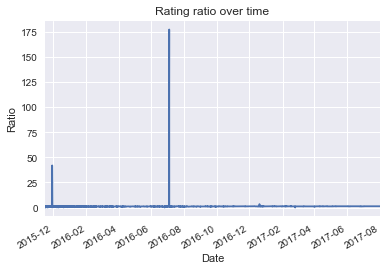

In [299]:
df['rating_ratio'].plot()
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Rating ratio over time')
plt.show()

In [287]:
df.describe()

,retweet_count,favorite_count,rating_numerator,rating_denominator,rating_ratio
count,1978.000000,1978.000000,1978.000000,1978.000000,1978.000000
mean,2729.792720,8890.946411,11.665319,9.998483,1.167052
std,4713.847831,12620.557290,40.803168,0.067454,4.080540
min,13.000000,80.000000,0.000000,7.000000,0.000000
25%,609.250000,1916.250000,10.000000,10.000000,1.000000
50%,1318.000000,4068.000000,11.000000,10.000000,1.100000
75%,3145.250000,11206.000000,12.000000,10.000000,1.200000
max,77758.000000,143980.000000,1776.000000,10.000000,177.600000


In [288]:
df_new=df[df['rating_ratio']<=1.2]

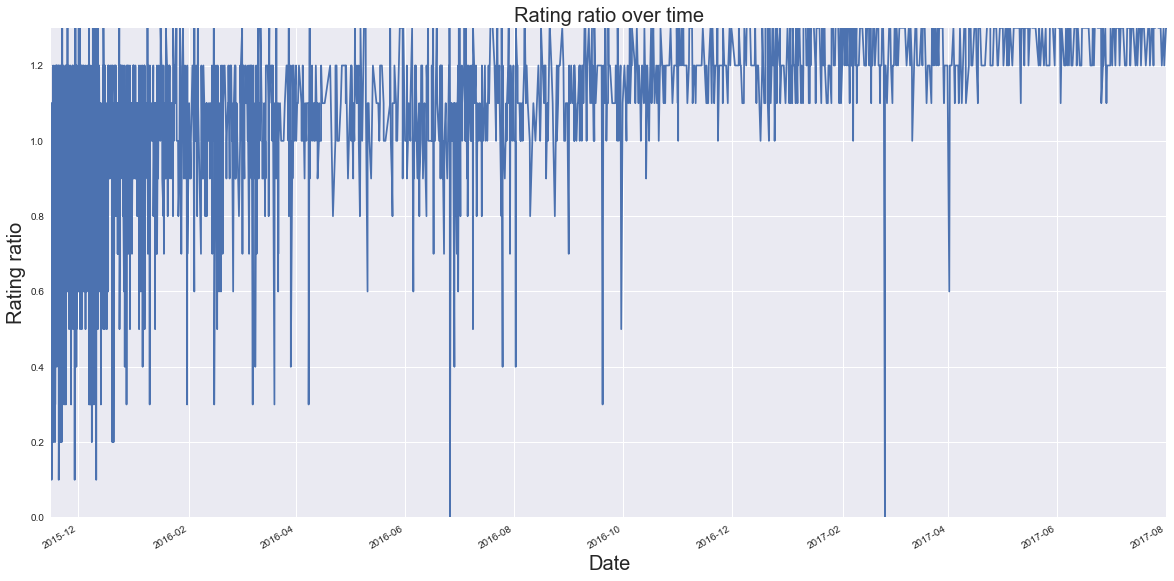

In [305]:
plt.figure(figsize=(20,10))
df['rating_ratio'].plot()
plt.ylabel('Rating ratio',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylim((0,1.3))
plt.title('Rating ratio over time',fontsize=20)
plt.savefig('ratio_over_time4.png')
plt.show();

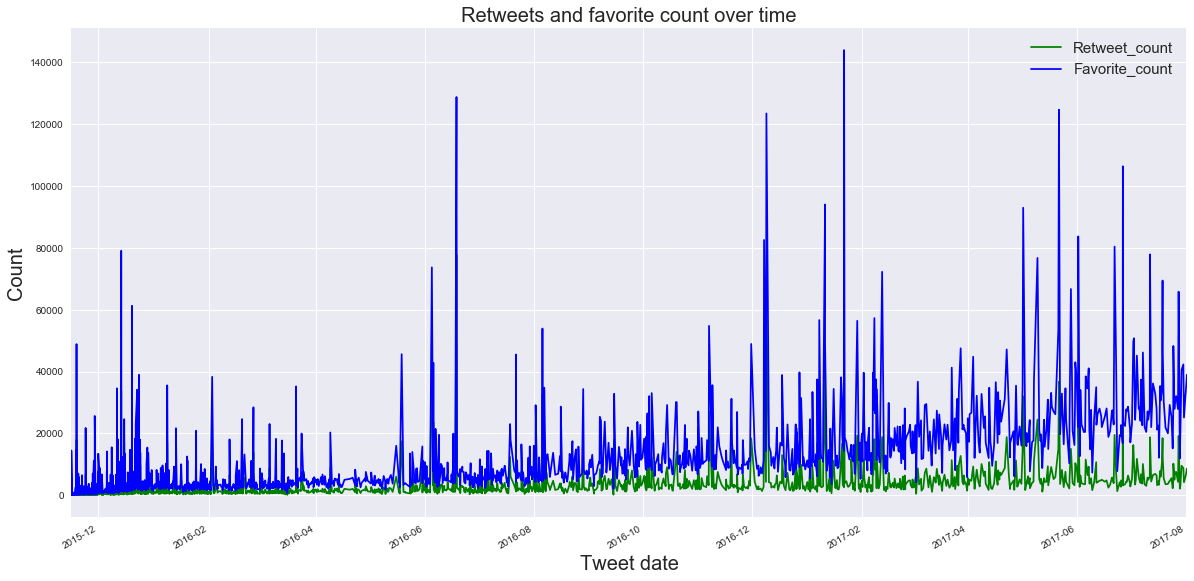

In [306]:
plt.figure(figsize=(20,10))
df['retweet_count'].plot(color = 'green', label='Retweet_count')
df['favorite_count'].plot(color = 'blue', label='Favorite_count')
plt.style.use('seaborn-darkgrid')
plt.legend(loc='upper right',fontsize=15)
plt.xlabel('Tweet date',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.title('Retweets and favorite count over time',fontsize=20)
plt.savefig('retweets_favorites2.png');

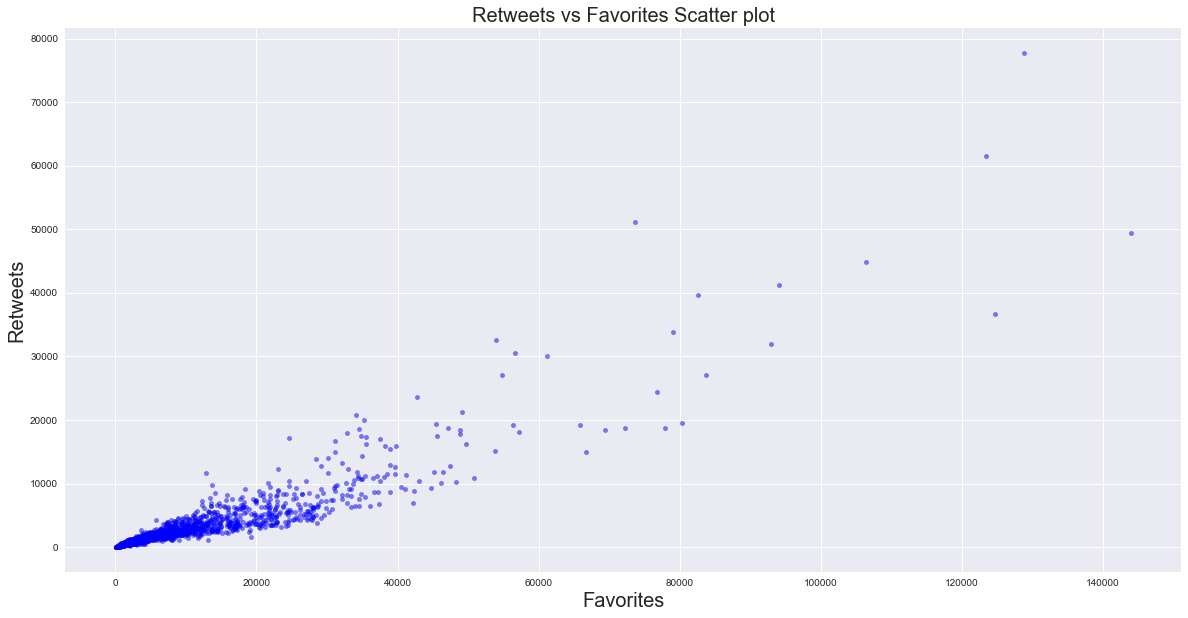

In [307]:
df.plot(kind = 'scatter', x = 'favorite_count', y = 'retweet_count', alpha = 0.5, color = 'blue',figsize=((20,10)))
plt.xlabel('Favorites',fontsize=20)
plt.ylabel('Retweets',fontsize=20)
plt.title('Retweets vs Favorites Scatter plot',fontsize=20)
plt.savefig('retweets_vs_favorites1.png');


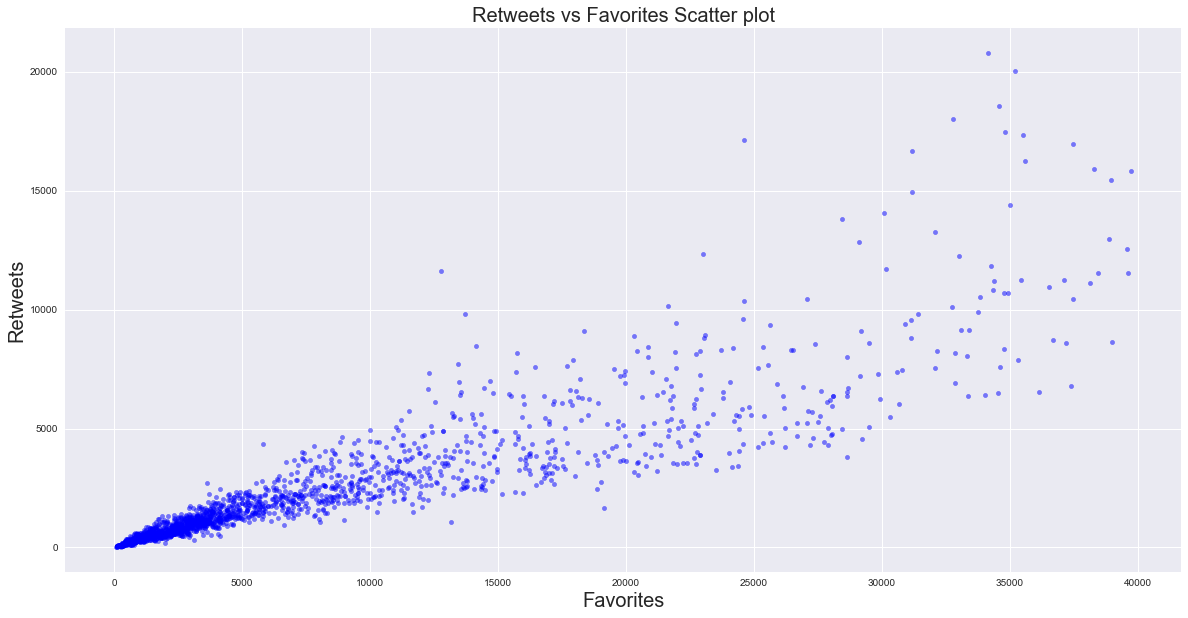

In [308]:
df[df['favorite_count']<40000].plot(kind = 'scatter', x = 'favorite_count', y = 'retweet_count', 
                                    alpha = 0.5, color = 'blue',figsize=((20,10)))
plt.xlabel('Favorites',fontsize=20)
plt.ylabel('Retweets',fontsize=20)
plt.title('Retweets vs Favorites Scatter plot',fontsize=20)
plt.savefig('retweets_vs_favorites2.png');

In [293]:
dog_stage_count = list(t_archive_clean[t_archive_clean['dog_stage'] != 'None']['dog_stage'].value_counts())[0:4]

In [294]:
dog_stage_count

[203, 74, 22, 7]

In [295]:
dog_stages = t_archive_clean[t_archive_clean['dog_stage'] != 'None']['dog_stage'].value_counts().index.tolist()[0:4]

In [296]:
dog_stages

['pupper', 'doggo', 'puppo', 'floofer']

In [297]:
explode = (0.2, 0.1, 0.1, 0.1) 

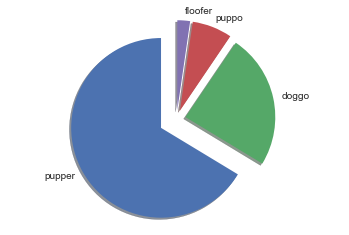

In [309]:
fig1, ax1 = plt.subplots()
ax1.pie(dog_stage_count, explode = explode, labels = dog_stages, shadow = True, startangle = 90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('pie_chart.png');


From the visualizations above one can make the following observations:
1. pupper seems to be the most popular dog stage in the WeRateDogs twitter archive.
2. There is a positive correlation betweetn Retweet count and favourite of tweets.
3. Retweet and favorite count shows a gradual increase with time
